<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/PROJETO_LH_PFC_PAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
from IPython.display import clear_output

In [ ]:
pip install open-ephys-python-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.7-py3-none-any.whl size=39989 sha256=0592bab4ac6af38db7e18af7c0ddc818dd00cdd3ce5a1080a8c0a8eb877bf3f2
  Stored in directory: /root/.cache/pip/wheels/99/0a/29/c0d2d399ff078b2a96c61e36a0a219a8fbb545a7acd261ce80
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=9411fe9e12158c3c8f37dce79a485bd5d7aafcc907772a1e255b7df3b358300a
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
! pip install pactools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.9 MB/s eta 0:00:00


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd


from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

import os
from PIL import Image
from scipy import signal



import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

> # FUNÇÕES



In [ ]:
def prewiew(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 45
  fc_high = 65
  order = 3
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preview_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
# CARREGAR O DADO COMPLETO

def load_data_full(path,ch_prl,ch_cg,ch_il):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_cg)-1)]
  data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_il)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL}))

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]

In [ ]:
def generating_masks_parado(path,ch,regiao): #ANIMAL PARADO

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  DATA = signal.filtfilt(b, a, data)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato) ) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original


  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)


  condition = (DATA >= -400) & (DATA <= 400) #eliminando ruídos

  index_sem_ruido = []

  for k in range(len(condition)):
      if condition[k] == True:
          index_sem_ruido.append(k)

  intersection = np.intersect1d(index_parado_all, index_sem_ruido) #fazendo a interseção entre condição(animal parado) e eliminação de ruídos

  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[intersection] = DATA[intersection]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan


  return(pd.DataFrame({'MASK': mask, 'regiao': regiao}))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def contador_de_tempo(data_para_contar):
  total_time = 0
  for i in range(len(data_para_contar)):
    total_time = total_time+ len(data_para_contar[i])/srate

  return total_time

In [ ]:
# CARREGAR OS DADOS DO ACELEROMETRO

def load_acelerometer(path):
    load = Session(path).recordnodes[0].recordings[0]
    t_raw = load.continuous[0].timestamps
    t = t_raw - t_raw[0]

    x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 32]
    y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 33]
    z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 34]

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    acel = np.abs(np.sqrt(x**2 + y**2 + z**2))

    df_acel = pd.DataFrame({'acel': acel})
    df_acel['animal'] = str(rato)
    df_acel['condicao'] = str(condicao)

    return df_acel

In [ ]:
def media_coherence(df, condicao, r1, r2):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao, 'regioes': str(r1)+'->'+str(r2)})
    return (result_df)

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
import random

def generating_surrogatos(lfp,numero_surrogatos):
    surrogatos = []
    for i in range(numero_surrogatos):
        split = random.randint(1, 90000)
        surro = np.concatenate([lfp[split:], lfp[:split]])
        surrogatos.append(surro)
    return surrogatos

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO PARA O SURROGATO

def pac_surro(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal)[mask])

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal)[mask])


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# # Causalidade de granger

# def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh, lag=-1):

#   envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
#   test_data_1 = np.squeeze(envelope_data_1)

#   envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
#   test_data_2 = np.squeeze(envelope_data_2)

#   matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
#   if lag == -1:
#     lag = [int(math.sqrt(len(matrix_test)))]
#   else:
#     lag = [lag]

#   gc = grangercausalitytests(matrix_test,lag,verbose = False)
#   results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

#   if results_test_r[0] != 0.0:
#     # print(results_test_r)
#     # print("Lag:", lag)

#     # p_label = []
#     # p = results_test_r[0]
#     # if p <= 0.01:
#     #   p_label.append('p<0.01')
#     # elif 0.01 < p < 0.05:
#     #   p_label.append('p<0.05')
#     # elif p == 0.05:
#     #   p_label.append('p=0.05')
#     # else:
#     #   p_label.append('p>0.05')

# df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': results_test_r[0], 'r1': r1, 'r2': r2, 'regioes': str(r1)+'->'+str(r2), 'condicao': condicao, 'lag':lag}, index=['Results'])

#   return(df_granger )

In [ ]:

def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 12
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)


> # ANÁLISE DOS DADOS

NormAmp = (Amp - min(Amp)) / (max(Amp) - min(Amp)))  [texto do link](https://www.frontiersin.org/articles/10.3389/fncir.2017.00029/full)

In [ ]:
ratos = { 'CCM497': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_POS_SCREEN'},

                      'canais': {'prl': 26,
                                  'cg': 14,
                                  'il': 3},

                      'inicio': { 'OF_pre': 50000,
                                  'OF_pos': 5000} ,  # VERIFICADO OF PRE E POS OK

                      # 'video': {'OF_pre':
                      #           'OF_pos':       },

                      'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_SCREENING'   },

         'CCM559': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_POS_SCREEN'},

                    'canais': {'prl': 28,
                               'cg': 22,
                               'il': 7 },

                    'inicio': { 'OF_pre': 390000,
                                'OF_pos': 205000    },

                                #           'video': {'OF_pre':
                                # 'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_SCREENING'    },

          # 'CCM56': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_PRE_SCREEN',
          #                        'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_POS_SCREEN' },

          #           'canais': { 'prl': 4,
          #                       'cg': 6,
          #                       'il': 24 },

          #           'inicio': { 'OF_pre': 40000,
          #                       'OF_pos': 140000   } ,
          #            'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_SCREENING'},

          'CCM04': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 25 },

                    'inicio': { 'OF_pre': 10000,
                               'OF_pos': 490000   } ,

                    'video': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/STRESS_mPFC-CATHERINE-2023-12-10/videos/CCM04_OF_PRE_SCREEN (1)DLC_resnet50_STRESS_mPFCDec10shuffle1_199500.csv'},
                              # 'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_SCREENING'     },

          'CCM05': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCM05_OF_POS_SCREEN_2' },

                    'canais': { 'prl':22 ,
                                'cg':29 ,
                                'il':27  },

                    'inicio': { 'OF_pre': 590000 ,
                                'OF_pos':  242000  } ,

                     'screening':  '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_SCREENING'},

          'CCM192': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_PRE_SCREEN',
                                  'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_POS_SCREEN' },

                      'canais': { 'prl': 24,
                                 'cg': 31,
                                 'il': 27},

                      'inicio': { 'OF_pre': 136000 ,
                                  'OF_pos':  170000  } ,        # VERIFICADO OF PRE E POS OK

                      'video': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/STRESS_mPFC-CATHERINE-2023-12-10/videos/Cópia de CCM192_OF_PRE_SCREENDLC_resnet50_STRESS_mPFCDec10shuffle1_199500.csv'},
                                # 'OF_pos':       },

                       'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_SCREENING'},

          'CCM193': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 28},

                    'inicio': { 'OF_pre': 200000,
                                'OF_pos':  390000 } ,   # VERIFICADO OF PRE E POS OK

                    # 'video': {'OF_pre':
                    #          'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_SCREENING'} }

> # ANALISE BASEADA NO ACELEROMETRO

>> # PARADO

In [ ]:
# CRIANDO DF Acelerometro
data_acel = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]

        df_temp_acel = load_acelerometer(str(path))
        data_acel.append(df_temp_acel)

df_acel = pd.concat(data_acel)
clear_output()

In [ ]:
# CRIANDO DF COM OS DADOS COMPLETOS

dataframes_full = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
      path = ratos[str(rato)]['condicao'][str(condicao)]

      ch_prl =  ratos[rato]['canais']['prl']
      ch_cg =  ratos[rato]['canais']['cg']
      ch_il =  ratos[rato]['canais']['il']

      df_temp_full = load_data_full(path, ch_prl, ch_cg, ch_il)
      df_temp_full['animal'] = str(rato)
      df_temp_full['condicao'] = str(condicao)

      dataframes_full.append(df_temp_full)

df_full = pd.concat(dataframes_full)
clear_output()

In [ ]:
# CRIANDO DF COM AS MASCARAS PARA FILTRAR RUIDOS E SEPARAR MOMENTOS DE IMOBILIDADE
dataframes_masks = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]

        ch_prl = ratos[rato]['canais']['prl']
        ch_acc = ratos[rato]['canais']['cg']
        ch_il = ratos[rato]['canais']['il']

        mask_data_prl = generating_masks_parado(path, ch_prl, 'PRL')
        mask_data_prl['animal'] = str(rato)
        mask_data_prl['condicao'] = str(condicao)


        dataframes_masks.append(mask_data_prl)

        mask_data_acc = generating_masks_parado(path, ch_acc, 'ACC')
        mask_data_acc['animal'] = str(rato)
        mask_data_acc['condicao'] = str(condicao)

        dataframes_masks.append(mask_data_acc)

        mask_data_il = generating_masks_parado(path, ch_il, 'IL')
        mask_data_il['animal'] = str(rato)
        mask_data_il['condicao'] = str(condicao)

        dataframes_masks.append(mask_data_il)


df_masks = pd.concat(dataframes_masks)
clear_output()


# > PAC na mesma região

⚠ revisar papers:

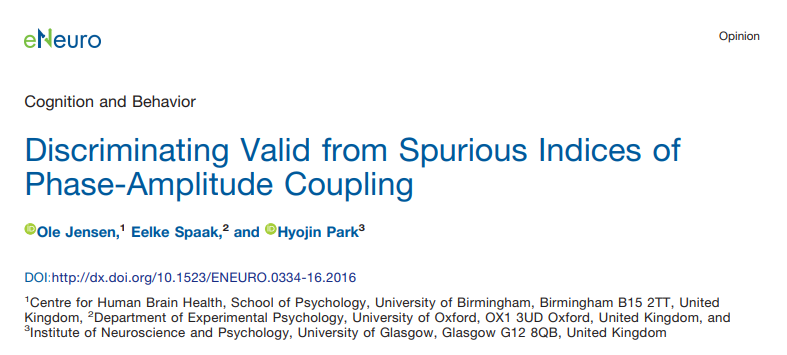

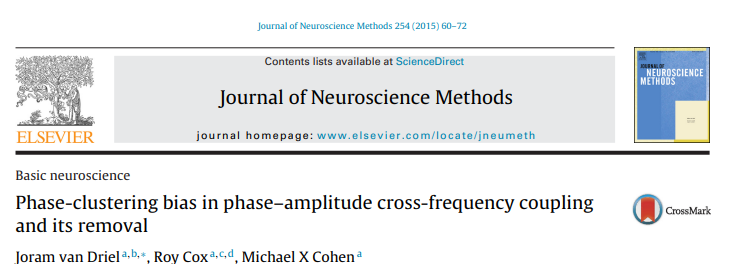

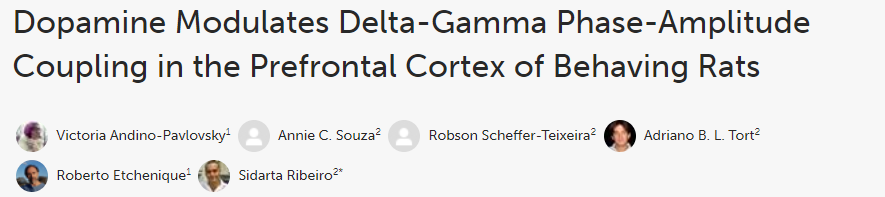

> # PAC PRL PRE

In [ ]:
df_full

,data_PRL,data_CG,data_IL,animal,condicao
0,130.818871,131.298688,103.751081,CCM497,OF_pre
1,67.407268,58.758306,100.709549,CCM497,OF_pre
2,59.602199,7.369465,12.141558,CCM497,OF_pre
3,27.813598,55.890460,42.433863,CCM497,OF_pre
4,-59.838434,-86.451103,-83.780613,CCM497,OF_pre
...,...,...,...,...,...
625195,22.826457,5.663405,86.956618,CCM193,OF_pos
625196,17.217932,-8.874513,62.933503,CCM193,OF_pos
625197,-17.821211,-26.357925,39.333750,CCM193,OF_pos
625198,-28.424612,-34.073326,38.098410,CCM193,OF_pos


In [ ]:
df_masks

,MASK,regiao,animal,condicao
0,999,PRL,CCM497,OF_pre
1,1000,PRL,CCM497,OF_pre
2,1001,PRL,CCM497,OF_pre
3,1002,PRL,CCM497,OF_pre
4,1003,PRL,CCM497,OF_pre
...,...,...,...,...
445154,625194,IL,CCM193,OF_pos
445155,625195,IL,CCM193,OF_pos
445156,625196,IL,CCM193,OF_pos
445157,625197,IL,CCM193,OF_pos


In [ ]:
data_prl_pre = []
mask_prl_pre = []

data_prl_pos = []
mask_prl_pos = []

data_acc_pre = []
mask_acc_pre = []

data_acc_pos = []
mask_acc_pos = []

data_il_pre = []
mask_il_pre = []

data_il_pos = []
mask_il_pos = []

for rato in ratos.keys():
  prl_pre = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_PRL']
  mask_PRL_pre = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pre') & (df_masks['regiao']=='PRL')]['MASK']
  data_prl_pre.append(prl_pre)
  mask_prl_pre.append(mask_PRL_pre)

  prl_pos = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pos')]['data_PRL']
  mask_PRL_pos = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pos') & (df_masks['regiao']=='PRL')]['MASK']
  data_prl_pos.append(prl_pos)
  mask_prl_pos.append(mask_PRL_pos)

  acc_pre = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_CG']
  mask_ACC_pre = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pre') & (df_masks['regiao']=='ACC')]['MASK']
  data_acc_pre.append(acc_pre)
  mask_acc_pre.append(mask_ACC_pre)

  acc_pos = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pos')]['data_CG']
  mask_ACC_pos = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pos') & (df_masks['regiao']=='ACC')]['MASK']
  data_acc_pos.append(acc_pos)
  mask_acc_pos.append(mask_ACC_pos)

  il_pre = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pre')]['data_IL']
  mask_IL_pre = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pre') & (df_masks['regiao']=='IL')]['MASK']
  data_il_pre.append(il_pre)
  mask_il_pre.append(mask_IL_pre)

  il_pos = df_full[(df_full['animal'] == str(rato)) & (df_full['condicao'] == 'OF_pos')]['data_IL']
  mask_IL_pos = df_masks[(df_masks['animal'] == str(rato)) & (df_masks['condicao'] == 'OF_pos') & (df_masks['regiao']=='IL')]['MASK']
  data_il_pos.append(il_pos)
  mask_il_pos.append(mask_IL_pos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(mask_prl_pre)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6

In [ ]:

def generating_surrogatos(lfp,numero_surrogatos):
    surrogatos = []
    for i in range(numero_surrogatos):
        split = random.randint(1, 90000)
        surro = np.concatenate([lfp[split:], lfp[:split]])
        surrogatos.append(surro)
    return surrogatos

In [ ]:
# CRIANDO SURROGATOS POR REGIÃO: PRL pre

lentaVector = np.arange(1,10,1) # bins para as ondas lentas (onde serão retiradas as fases)
altaVector = np.arange(30,150,10) # bins para as ondas rápidas (onde serão retiradas as amplitudes)
lenta_BandWidth = 2 # resolução para as lentas
alta_BandWidth = 10 # resolução para as rápidas
numbin = 18 #esse numero é fixo, manter sempre 18
numero_surrogatos = 2 #quantidade de surrogatos que vão ser gerados

n_animals = 6

surrogatos = []
pac_prl_pre_all = []

# calculando os pacs para os surrogatos

for i in range(n_animals):
  mask = mask_prl_pre[i]
  pac_prl_surr_pre = []
  lfp = data_prl_pre[i][mask]
  surrogato = generating_surrogatos(lfp[0:90000], numero_surrogatos)
  for j in range(numero_surrogatos):
    faz_pac_prl_pre = pac_surro(surrogato[j],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
    pac_prl_surr_pre.append(faz_pac_prl_pre)

  pac_prl_pre_all.append(pac_prl_surr_pre)


# SALVANDO OS RESULTADOS EM CSV

# df_pac_surro = pd.DataFrame(pac_prl_pre_all)
# df_pac_surro = df_pac_surro.T
# # Save to Google Sheets (make sure to replace 'your_spreadsheet_id' with the actual ID)
# df_pac_surro.to_csv('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/CSV_ANALYZED_DATA/Surrogatos_300_PRL.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# COMPUTANDO O PAC DO SINAL ORIGINAL

lentaVector = np.arange(1,10,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18


pac_prl_pre = []

for i in range(6):
  mask_pre = mask_prl_pre[i]
  pac_pre = pac(data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_pre)
  pac_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_pre,axis = 0)

pac_prl_pos = []

for i in range(6):
  mask_pos = mask_prl_pos[i]
  pac_pos = pac(data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,mask_pos)
  pac_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_prl_pos,axis = 0)



In [ ]:

# def verificando_pac(data_pac_surro, pac_original, n_animals  ):

pac_after_surro = []

for i in range(n_animals):
  threshold_perc = np.percentile(np.array(pac_prl_pre_all[i]), 97.5,axis = 0)
  arr_pacs_original = np.array(pac_prl_pre[i])
  result_pac = np.where(arr_pacs_original < threshold_perc, 0, arr_pacs_original)
  pac_after_surro.append(result_pac)

pac_verified = np.mean(pac_after_surro, axis = 0) #esta variável vai conter a média dos 6 animais, após passar pela verificação

  # return pac_verified

<ipython-input-105-e3069dbf93b2>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


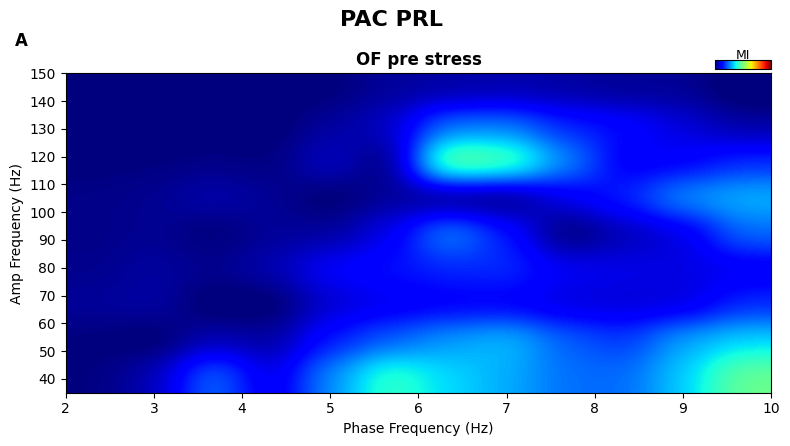

In [ ]:
#  PLOTANDO OS RESULTADOS

pac_plot_pre = pac_verified #colocar nessa variável o dado que vc quer plotar (PRE)
# pac_plot_pos = data_pac_pos #colocar nessa variável o dado que vc quer plotar (POS)


vmin = 0.000009#np.percentile(data_pac_pre, 2.5) #ESSE VALOR PODE SER ALTERADO SE NECESSARIO
vmax = np.percentile(data_pac_pre, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL ', fontweight ="bold", fontsize = 16) #MUDAR O NOME DA REGIÃO

# figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(pac_plot_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

# figura.add_subplot(122)


# vmin =  0.0001
# vmax = np.percentile(data_pac_pos, 97.5)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(pac_plot_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('Phase Frequency (Hz)')
# plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)


# plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
vmin

7.399152183039587e-06

In [ ]:
vmax

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.00047654343316779054

<ipython-input-41-155967848c62>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


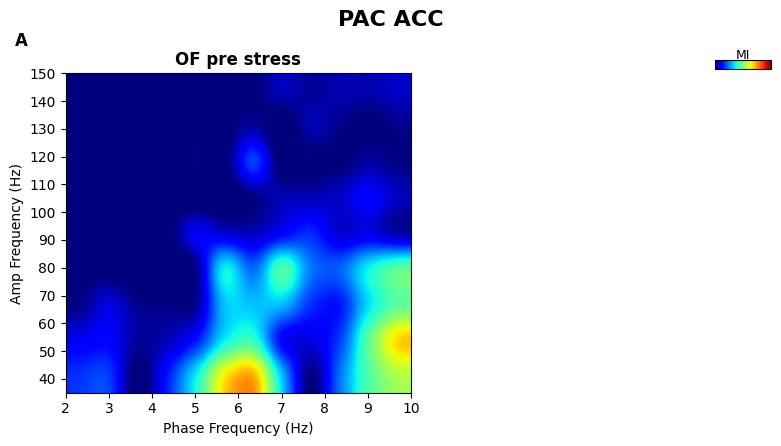

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# PLOTANDO OS RESULTADOS

pac_plot_pre = pac_verified #colocar nessa variável o dado que vc quer plotar (PRE)
# pac_plot_pos = #colocar nessa variável o dado que vc quer plotar (POS)


vmin = 0.00004 #ESSE VALOR PODE SER ALTERADO SE NECESSARIO
vmax = np.percentile(data_pac_pre, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC ACC ', fontweight ="bold", fontsize = 16) #MUDAR O NOME DA REGIÃO

figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(pac_plot_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

# figura.add_subplot(122)


# vmin =  0.0004
# vmax = np.percentile(data_pac_pos, 97.5)

# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(pac_plot_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

# plt.xlabel('Phase Frequency (Hz)')
# plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


# cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
# cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
# cbar.set_label('MI')
# cbar.ax.xaxis.set_label_coords(0.5, 2.2)
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.ax.xaxis.label.set_fontsize(9)


plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:


# vmin = 0.00001
# vmax = 0.00075

vmin =  0.0004
vmax = np.percentile(data_pac_pre, 97.5)  # Define vmax como o 95º percentil


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)


vmin =  0.0004
vmax = np.percentile(data_pac_pos, 97.5)


plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')


cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:


vmin = 0.00002
vmax = 0.00065



figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)

plt.title('OF pos stress', fontweight ="bold")



extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')


cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:


lentaVector = np.arange(1,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_cg_pre = []

for i in range(6):
  pac_pre = pac(data_cg_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_pre,axis = 0)

pac_cg_pos = []

for i in range(6):
  pac_pos = pac(data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_pos,axis = 0)

In [ ]:
# vmin = 0.00003
# vmax = 0.00094

vmin = 0.0004
vmax = np.percentile(data_pac_pre, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC ACC ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)


vmin =  0.0004
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
# pac parameters IL

lentaVector = np.arange(1,10,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_il_pre = []

for i in range(6):
  pac_pre = pac(data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_pre,axis = 0)

pac_il_pos = []

for i in range(6):
  pac_pos = pac(data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_pos,axis = 0)

In [ ]:

vmin = 0.0002
vmax = np.percentile(data_pac_pre, 97.5)



figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL ', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

figura.add_subplot(122)

vmin =  0.0002
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('Phase Frequency (Hz)')
plt.ylabel('Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

# PAC DUAS REGIÕES

In [ ]:
data_prl_pre = []
data_prl_pos = []
data_cg_pre = []
data_cg_pos = []
data_il_pre = []
data_il_pos = []

for rato in ratos.keys():
  prl_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_PRL']
  data_prl_pre.append(prl_pre)

  prl_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_PRL']
  data_prl_pos.append(prl_pos)

  cg_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_CG']
  data_cg_pre.append(cg_pre)

  cg_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_CG']
  data_cg_pos.append(cg_pos)

  il_pre = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre')]['data_IL']
  data_il_pre.append(il_pre)

  il_pos = df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos')]['data_IL']
  data_il_pos.append(il_pos)

In [ ]:
# CRIANDO SURROGATOS POR REGIÃO: PRL e ACC

lentaVector = np.arange(1,10,1) # bins para as ondas lentas (onde serão retiradas as fases)
altaVector = np.arange(30,150,10) # bins para as ondas rápidas (onde serão retiradas as amplitudes)
lenta_BandWidth = 2 # resolução para as lentas
alta_BandWidth = 10 # resolução para as rápidas
numbin = 18 #esse numero é fixo, manter sempre 18
numero_surrogatos = 100 #quantidade de surrogatos que vão ser gerados

n_animals = 6

surrogatos = []
pac_prl_cg_pre_all = []

# calculando os surrogatos
for i in range(n_animals):
  pac_prl_cg_pre = []
  lfp_phase = data_cg_pre[i]
  lfp_amplitude = data_prl_pre[i]-np.mean(data_prl_pre[i])

  surrogato = generating_surrogatos(lfp_phase, numero_surrogatos)
  for j in range(numero_surrogatos):
    pac_pre = pac_entre_regioes(lfp_amplitude,surrogato[j],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin,)
    pac_prl_cg_pre.append(pac_pre)

  pac_prl_cg_pre_all.append(pac_prl_cg_pre)


#data_pac_pre = np.mean(pac_prl_cg_pre,axis = 0)

#surro = generating_surrogatos(data_prl_pre[0],300)
#print(surro)

In [ ]:
pac_prl_cg_afterSurro = []

for i in range(n_animals):
  threshold_perc = np.percentile(np.array(pac_prl_cg_pre_all[i]), 97.5,axis = 0)
  arr_pacs = np.array(pac_prl_cg_pre[i])
  result_pac = np.where(arr_pacs < threshold_perc, 0, arr_pacs)
  pac_prl_cg_afterSurro.append(result_pac)


In [ ]:
# CALCULANDO A MEDIA DOS PACS APÓS VERIFICAÇÃO

pac_verified = np.mean(pac_prl_cg_afterSurro,axis = 0)


array([[0.00000000e+00, 1.38670800e-04, 1.37559698e-04, 0.00000000e+00,
        0.00000000e+00, 1.89078727e-04, 2.54612178e-04, 9.61901451e-05,
        0.00000000e+00, 0.00000000e+00, 2.60506025e-04, 3.54696282e-04],
       [6.35804531e-05, 1.17382470e-04, 6.29038243e-05, 0.00000000e+00,
        1.09440614e-04, 1.74003003e-04, 1.46163315e-04, 2.61042153e-04,
        2.33415560e-04, 2.48401445e-04, 2.73954854e-04, 3.14576681e-04],
       [0.00000000e+00, 0.00000000e+00, 3.79409988e-05, 0.00000000e+00,
        8.93205812e-05, 1.88120102e-04, 1.54018464e-04, 1.75235497e-04,
        6.13295615e-05, 5.31970656e-05, 1.45614003e-04, 1.60450382e-04],
       [0.00000000e+00, 3.38475164e-05, 0.00000000e+00, 0.00000000e+00,
        4.02978378e-05, 1.05945828e-04, 1.69316268e-04, 2.39514849e-04,
        1.77925407e-04, 8.65059586e-05, 1.44291345e-04, 1.84020903e-04],
       [2.34095448e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.21020081e-04, 2.31923798e-04, 3.76184302e-04, 3.88

In [ ]:
# SAVING SURROGATES PACS IN CSV FILE

import pandas as pd

# Create a DataFrame from the list
df_pac_surro = pd.DataFrame(pac_prl_cg_pre_all)
df_pac_surro = df_pac_surro.T
# Save to Google Sheets (make sure to replace 'your_spreadsheet_id' with the actual ID)
# df_pac_surro.to_csv('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/CSV_ANALYZED_DATA/Surrogatos_100.csv', index = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# pac parameters PRL CG

lentaVector = np.arange(1,10,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18



pac_prl_cg_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_prl_pre[i]-np.mean(data_prl_pre[i]),data_cg_pre[i]-np.mean(data_cg_pre[i]),lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_cg_pre,axis = 0)

# pac_prl_cg_pos = []

# for i in range(6):
#   pac_pos = pac_entre_regioes(data_prl_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
#   pac_prl_cg_pos.append(pac_pos)

# data_pac_pos = np.mean(pac_prl_cg_pos,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored

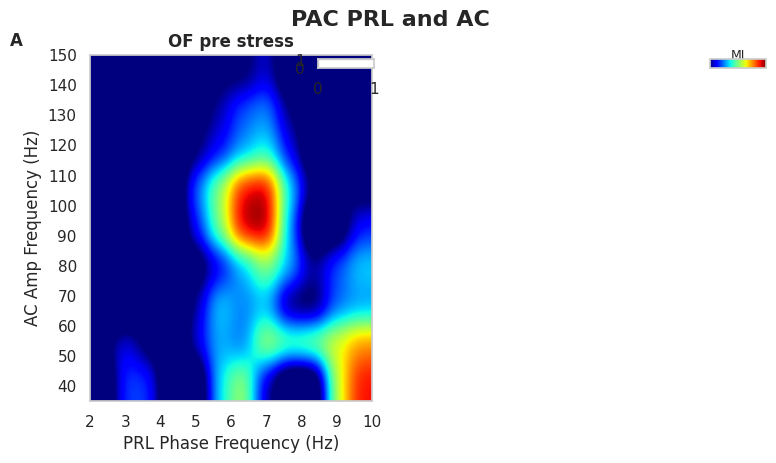

In [ ]:
# pac parameters prl ac

vmin =8e-5

# vmax = 0.00008
# vmax = np.percentile(data_pac_pre, 97.5)

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL and AC', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(pac_verified,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))
plt.grid(False)
plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

# figura.add_subplot(122)

# vmin = 4e-5
# # vmax = np.percentile(data_pac_pre, 97.5)

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)


# plt.title('OF pos stress', fontweight ="bold")

# extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
# im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

# plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
# plt.gca().invert_yaxis()
# plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))
# plt.grid(False)
# plt.xlabel('PRL Phase Frequency (Hz)')
# plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "A", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")


cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.5, 1.15, "B", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
# plt.grid(False)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_AC_4animais.jpeg')

In [ ]:
# pac parameters  CG prl

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,80,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_cg_prl_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_cg_pre[i],data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_prl_pre,axis = 0)

pac_cg_prl_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_cg_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_prl_pos,axis = 0)

<ipython-input-38-5ebf09df3b3b>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


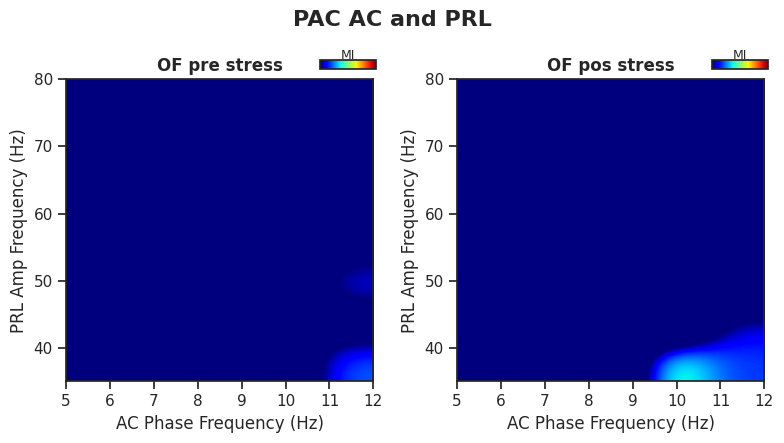

In [ ]:
# # pac parameters AC prl

vmin = 0.0002
vmax = np.percentile(data_pac_pre, 97.5)

# vmin = np.percentile(data_pac_pre, 5)  # Define vmin como o 5º percentil
# vmax = np.percentile(data_pac_pre, 95)  # Define vmax como o 95º percentil



figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC AC and PRL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

figura.add_subplot(122)


vmin = 0.0002
vmax = np.percentile(data_pac_pos, 97.5)
plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_AC_PRL_4animais.jpeg')
# plt.show()

In [ ]:
# # pac parameters   il PRL

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_il_prl_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes( data_il_pre[i], data_prl_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_prl_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_prl_pre,axis = 0)

pac_il_prl_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_il_pos[i],data_prl_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_prl_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_prl_pos,axis = 0)

<ipython-input-40-97627cfb0c75>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


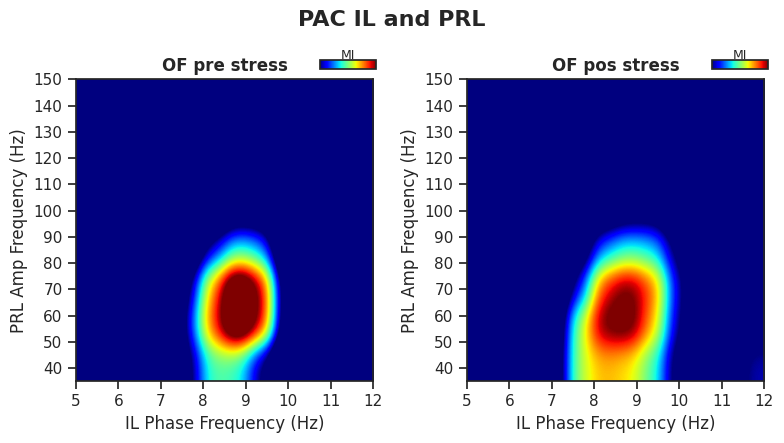

In [ ]:
# #pac parameters

# vmin = 0.000001
# vmax = 0.000009

vmin = 0.0006
vmax = np.percentile(data_pac_pre, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL and PRL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

figura.add_subplot(122)

vmin = 0.0006
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('PRL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_IL_PRL_4animais.jpeg')


In [ ]:
vmax

0.0005643805762670307

In [ ]:
# # pac parameters  PRL il

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_prl_il_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_prl_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_prl_il_pre,axis = 0)

pac_prl_il_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_prl_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_prl_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_prl_il_pos,axis = 0)

<ipython-input-48-36911d9ef99b>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


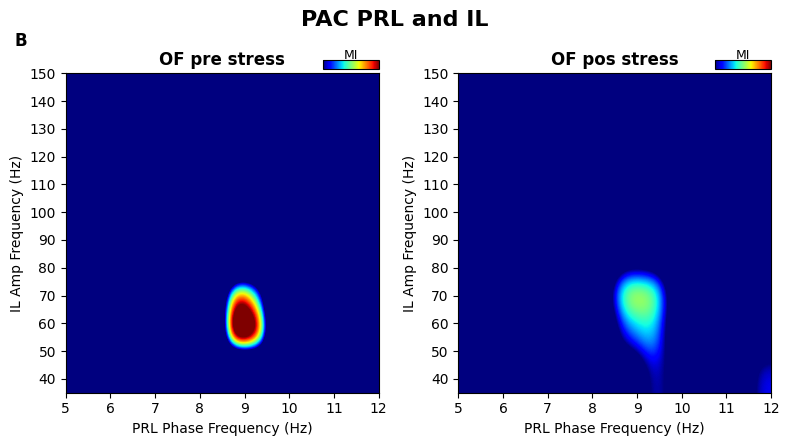

In [ ]:
# #pac parameters



vmin = 0.0004
vmax = np.percentile(data_pac_pre, 97.5)

figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC PRL and IL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

figura.add_subplot(122)

vmin = 0.0004
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('PRL Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "B", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_PRL_IL_4animais.jpeg')

In [ ]:
# # pac parameters  CG il

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_cg_il_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_cg_pre[i],data_il_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_il_pre.append(pac_pre)

data_pac_pre = np.mean(pac_cg_il_pre,axis = 0)

pac_cg_il_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_cg_pos[i],data_il_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_cg_il_pos.append(pac_pos)

data_pac_pos = np.mean(pac_cg_il_pos,axis = 0)

<ipython-input-54-3e01eb54003a>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


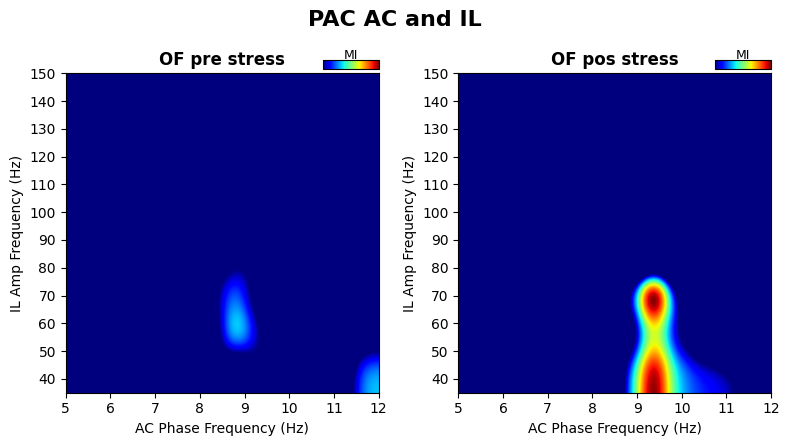

In [ ]:
# # pac parameters

vmin = 0.0002
vmax = np.percentile(data_pac_pre, 97.5)


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC AC and IL', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

figura.add_subplot(122)

vmin = 0.0002
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('AC Phase Frequency (Hz)')
plt.ylabel('IL Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(-0.1, 0.9, "C", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_AC_IL_4animais.jpeg')

In [ ]:
# # pac parameters   il cg

lentaVector = np.arange(4,12,1)
altaVector = np.arange(30,150,10)
lenta_BandWidth = 2
alta_BandWidth = 10
numbin = 18

pac_il_cg_pre = []

for i in range(6):
  pac_pre = pac_entre_regioes(data_il_pre[i],data_cg_pre[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pre.append(pac_pre)

data_pac_pre = np.mean(pac_il_cg_pre,axis = 0)

pac_il_cg_pos = []

for i in range(6):
  pac_pos = pac_entre_regioes(data_il_pos[i],data_cg_pos[i],lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,1000,numbin)
  pac_il_cg_pos.append(pac_pos)

data_pac_pos = np.mean(pac_il_cg_pos,axis = 0)

<ipython-input-60-bc6f98916455>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


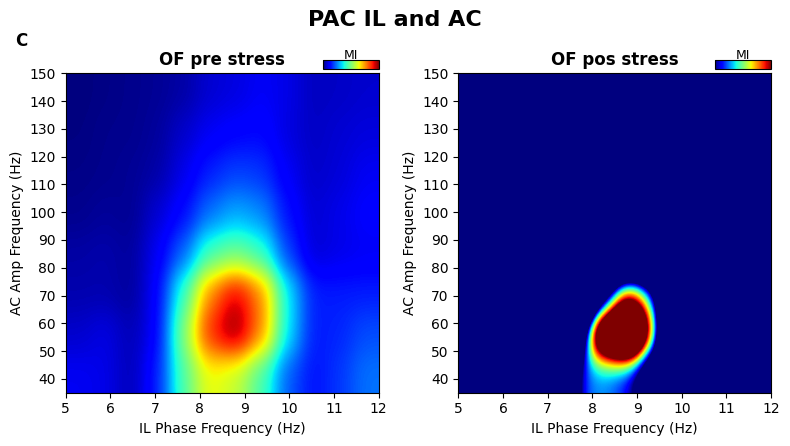

In [ ]:
# # pac parameters
vmin = 0.0009
vmax = np.percentile(data_pac_pre, 97.5)


figura = plt.figure(figsize=(8,4.5))
figura.suptitle('PAC IL and AC', fontweight ="bold", fontsize = 16)
# gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1.5])
figura.add_subplot(121)

plt.title('OF pre stress', fontweight ="bold")
extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im1 = plt.imshow(data_pac_pre,extent = extent,interpolation = 'gaussian',cmap = 'jet',aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

figura.add_subplot(122)

vmin = 0.0009
vmax = np.percentile(data_pac_pos, 97.5)

plt.title('OF pos stress', fontweight ="bold")

extent = [lentaVector[0]+lenta_BandWidth/2,lentaVector[-1]+lenta_BandWidth/2,(altaVector[-1]+alta_BandWidth/2)+5,altaVector[0]+alta_BandWidth/2]
im2 = plt.imshow(data_pac_pos,extent = extent,interpolation = 'gaussian',cmap = 'jet',vmin = vmin, vmax = vmax,aspect = 'auto', label = 'PRL OF pre secreening')

plt.yticks(ticks = ((altaVector+alta_BandWidth/2)+5).astype(int))
plt.gca().invert_yaxis()
plt.xticks(ticks = np.round((lentaVector+lenta_BandWidth/2)-0.2).astype(int))

plt.xlabel('IL Phase Frequency (Hz)')
plt.ylabel('AC Amp Frequency (Hz)')

cax = figura.add_axes([0.9, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
cax.text(-12.5, 4, "C", transform=cax.transAxes, fontsize=12, fontweight="bold", va="top")

cax = figura.add_axes([0.41, 0.85, 0.07, 0.02])
cbar = figura.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label('MI')
cbar.ax.xaxis.set_label_coords(0.5, 2.2)
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.ax.xaxis.label.set_fontsize(9)
# cax.text(0.66, 0.9, "D", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top")

plt.subplots_adjust(wspace=0.20)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/figures/PAC_IL_AC_4animais.jpeg')

In [ ]:
low_fq_range = np.arange(1,12,0.2)  # Frequência baixa de 1 a 12 Hz
high_fq_limit = 100  # Limite da frequência alta em 100 Hz

estimator = Comodulogram(fs=1000, low_fq_range=low_fq_range,
                         low_fq_width=1, high_fq_range=(low_fq_range[-1], high_fq_limit),
                         method='tort', progress_bar=False)
estimator.fit(prl)
estimator.plot()
estimator.get_maximum_pac()

plt.show()


# COMODULOGRAM

In [ ]:
low_fq_range = np.arange(1,12,0.2)  # Frequência baixa de 1 a 12 Hz
high_fq_limit = 100  # Limite da frequência alta em 100 Hz

estimator = Comodulogram(fs=1000, low_fq_range=low_fq_range,
                         low_fq_width=1, high_fq_range=(low_fq_range[-1], high_fq_limit),
                         method='tort', progress_bar=False)
estimator.fit(prl)
estimator.plot()
estimator.get_maximum_pac()

plt.show()
